# Self-orginizing maps

Self-orginizing map (SOM) is a type of neural network which is trained using unsupervised learning algorithms. One of the basic abilities of SOM is to project high-dimensional data to lower dimension (1D, 2D, 3D obviously). SOM can be considered as a general cluster analysis tool.

Scheme of 2D SOM:

![SOM](https://miro.medium.com/max/655/1*QG7afWQKjY3IpezhNQMzBg.png)

2D SOM consists of neurons in a plane, each neuron has *n* number of weights, where *n* equals to input data dimension. 

Positions of neurons are determined by any kind of distance metrics. For our pupose the Euclidean distance is sufficient.

Euclidean distance between two neurons with weights vector $\boldsymbol{w_1}$ and $\boldsymbol{w_2}$:

$$||\boldsymbol{w_1}-\boldsymbol{w_2}||= \sqrt{\sum_{j=1}^{p}(w_{1j}-w_{2j})^2}$$



## Learning algorithm


![SOMlearn](https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif)

1. The weights $\boldsymbol{w(0)}$ have random values in initialization step. 
2. Random observation $\boldsymbol{x}(k)$ is chosen from input data
3. Calculate the distance (e.g. Euclidean) between chosen observation and all neuron weights
4. Find which neuron is the closest to chosen observation. This is our winning neuron $v = arg~min ||\boldsymbol{x}(k) - \boldsymbol{w}||$
5. Update winning neuron weights $\boldsymbol{w_v}$: $$\boldsymbol{w_v}(k+1) = \boldsymbol{w_v}(k) + \alpha(k) [\boldsymbol{x}(k) - \boldsymbol{w_v}(k)]$$ where $\alpha(k)$ is a learning parameter which should be high at the beginning and low at the end of learning algorithm. We want to make bigger steps at the beginning of learning and then finer and finer: $$\alpha(k) = \alpha(0) \exp\left({- \frac{k}{\lambda_\alpha}}\right)$$
6. However it is important to update also the neighbour neurons $\boldsymbol{w_n}(k)$ of the winning neuron. This is crucial for finding similar clusters of neurons (this is the basic formula of learning algorithm): $$\boldsymbol{w_n}(k+1) = \boldsymbol{w_n}(k) + \alpha(k)\eta(v,k,n) [\boldsymbol{x}(k) - \boldsymbol{w_v}(k)]$$ The update is similar to winning neuron update but it has additional neighbourhood parameter $\eta(v,k,n)$, which determines how much are the neighbours influenced by the winning neuron. The closest neighbours are influenced the most and the influence is gettig weaker with bigger distance according to: $$\eta = exp\left( -\frac{||n-v||^2}{2 \sigma(k)^2}  \right)$$ which is a gaussian function where $||n-v||$ is distance between winning neuron and the neighbour and $\sigma(k)$ is a parameter which determines how wide is the neighbourhood area. $\sigma(k)$ should be also high at the beginning and low at the end of the algorithm: $$\sigma(k) = \sigma(0) \exp\left({- \frac{k}{\lambda_\sigma}}\right)$$
7. Go to step 2. and repeat 



## Simple 2D SOM example

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Define a function for 2D SOM creation. SOM has some number of neurons determined by number of rows and columns in SOM plane and is also determined by number of weights of each neuron

In [2]:
def new_SOM(nRows, nCols, nWeights):
    som = np.random.rand(nRows, nCols, nWeights) #random initialization
    return som

Define a function which finds the winning neuron and returns its position and distance between the winner and the observation from input data

In [3]:
def find_winner(som, x):
    #initialization
    dist_win = np.inf
    row_win = np.nan
    col_win = np.nan
    nRowsSOM = som.shape[0]
    nColsSOM = som.shape[1]
    
    #go through the som
    for row in range(nRowsSOM):
        for col in range(nColsSOM):
            #calculate euclidean distance between neuron and input data
            currentCentroidDistance = np.sqrt(sum((som[row, col, :]-x)**2))
            #find the closest one
            if currentCentroidDistance < dist_win:
                dist_win = currentCentroidDistance
                row_win = row
                col_win = col
                
    return row_win, col_win, dist_win

Define a function for Euclidean distance between neurons

In [4]:
def distance_in_map(row1, col1, row2, col2):
    return np.sqrt((row1-row2)**2+(col1-col2)**2)

Finally the learning algorithm. Inputs are our SOM, input datax, iteration index and parameters of learning: 
* sigma0 is initial size of neighbourhood
* alpha0 is initial learning parameter
* lambdaSigma determines how quickly will neighbourhood influence decrease during the algorithm
* lambaAlpha determines how quickly will learning parameter decrease during the algorithm

In [5]:
def training(som, x, iteration, sigma0, alpha0, lambdaSigma, lambdaAlpha):
    row_win, col_win, dist_win = find_winner(som, x)
    nRowsSOM = som.shape[0]
    nColsSOM = som.shape[1]
    #alpha parameter is getting lower during the algorithm
    alphaIteration = alpha0 * np.exp(-iteration/float(lambdaAlpha)) 
    #Sigma parameter is getting lower during the algorithm
    sigmaIteration = sigma0 * np.exp(-iteration/float(lambdaSigma))
    
    #Go through rows and columns
    for row in range(nRowsSOM):
        for col in range(nColsSOM):
            #this is the main formula as in step 6.
            deltaWeights = (x - som[row, col, :]) * \
            alphaIteration * np.exp(-distance_in_map(row, col, row_win, col_win)**2 / float(sigmaIteration)**2)
            som[row, col, :] = som[row, col, :] + deltaWeights
    return som
    

## Let's apply the SOM!

We would like to distinguish color clusters. Input data will have 3 dimensions (RGB values)

In [6]:
colors = [[1,0,0], [0,1,0], [0,0,1]] #three basic colors

data = []
#create a noisy RGB input data
for i in range (150): 
    #choose one of the colors and add noise
    data.append(colors[np.random.randint(0,3)]+np.random.rand(3)/5.)
    #color value should be in range <0;1>
    data[-1] = np.clip(data[-1],0.0,1.0)

Now create a SOM and plot it as an image. You will see random pixels

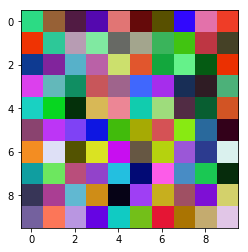

In [7]:
som = new_SOM(10,10,3)
plt.imshow(som)
plt.show()

Try 10 learning iterations. SOM weights will get closer to input data and will cluster similar pixels

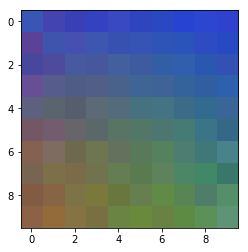

In [8]:
#You can try to play with the parameters and test the learning behaviour
sigma0 = 10
alpha0 = 0.5
lambdaSigma = 30
lambdaAlpha = 20

for i in range(10):
    som = training(som,  data[i], i+1, sigma0, alpha0, lambdaSigma, lambdaAlpha)

plt.imshow(som)
plt.show()

More and more interations

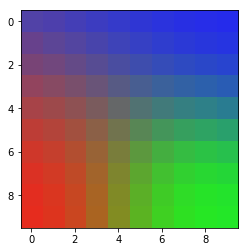

In [9]:
for i in range(40):
    som = training(som,  data[i], i+1, sigma0, alpha0, lambdaSigma, lambdaAlpha)

plt.imshow(som)
plt.show()

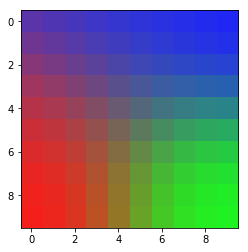

In [10]:
for i in range(100):
    som = training(som,  data[i], i+1, sigma0, alpha0, lambdaSigma, lambdaAlpha)

plt.imshow(som)
plt.show()

We made a visualization of neuron weights using RGB. 
We will plot the winning neurons now.

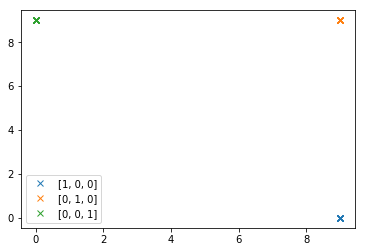

In [11]:
plt.figure()
#for each color (RGB) find the winner
for colour in [[1,0,0],[0,1,0],[0,0,1]]:
    X = []
    Y = []
    for i in range(10):
        #find the winner from noisy data
        row, col, d = find_winner(som, np.array(colour)+np.random.rand(3)/5.)
        X.append(col)
        Y.append(row)
    plt.plot(Y,X,"x", label=str(colour))
plt.legend()
plt.show()